<a href="https://colab.research.google.com/github/edwarddramirez/taxi-forecast/blob/main/Copy_of_taxi_pulocation_simple_fit_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/taxi_colab', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [3]:
# instant if installed, ~10 min if loading from Drive
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import geopandas as gpd
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

import torch
import torch_geometric
import torch_geometric_temporal

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

### Load Data

In [4]:
ts = pd.read_csv('/content/mnt/MyDrive/adjusted_yellow_2022-01_2024-03_bypulocation.csv')




#/content/mnt/MyDrive/adjusted_yellow_2022-01_2024-03_bypulocation.csv


In [5]:
gdf = gpd.GeoDataFrame(pd.read_csv('/content/notebooks/manhattan_taxi_zones.csv'))



In [22]:
# #ts = pd.read_csv('/content/mnt/My Drive/taxi_data/adjusted_yellow_2023-01_2023-03_bypulocation.csv')
# # gdf = gpd.GeoDataFrame(pd.read_csv('/content/mnt/My Drive/taxi_data/manhattan_taxi_zones.csv'))

# #ts = pd.read_pickle('/content/mnt/MyDrive/adjusted_yellow_2022-01_2024-03_bypulocation.pkl') # in taxi_colab folder
# ts = pd.read_pickle('/content/mnt/MyDrive/taxi_colab/Adjusted/adjusted_yellow_2022-01_2024-03_bypulocation.pkl')


# #gdf = gpd.GeoDataFrame(pd.read_pickle('/content/notebooks/manhattan_taxi_zones.pkl'))

# #ts = pd.read_pickle('/content/notebooks/adjusted_yellow_2022-01_2024-03_bypulocation.pkl')
# # ts = pd.read_pickle('/content/mnt/My Drive/taxi_data/adjusted_yellow_2023-01_2023-03_bypulocation.pkl')
# #gdf = gpd.GeoDataFrame(pd.read_pickle('/content/mnt/My Drive/taxi_data/manhattan_taxi_zones.pkl'))

In [23]:
ts.head()

,Unnamed: 0,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,0,4,2022-01-01 00:00:00-05:00,8,23.242388,1.886513,16.681875,3.363750,1.375000,14.481250
1,1,12,2022-01-01 00:00:00-05:00,1,36.592500,6.088500,25.830000,5.600000,4.000000,22.650000
2,2,13,2022-01-01 00:00:00-05:00,10,27.196531,3.027030,19.495500,4.386000,1.300000,14.801666
3,3,24,2022-01-01 00:00:00-05:00,10,18.574230,1.846230,12.915000,2.242000,1.200000,11.380000
4,4,41,2022-01-01 00:00:00-05:00,9,21.188799,1.549800,15.648334,3.082222,1.777778,13.890740


In [24]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236501 entries, 0 to 1236500
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1236501 non-null  int64  
 1   PULocationID     1236501 non-null  int64  
 2   pickup_datetime  1236501 non-null  object 
 3   counts           1236501 non-null  int64  
 4   total_amount     1236501 non-null  float64
 5   tip_amount       1236501 non-null  float64
 6   fare_amount      1236501 non-null  float64
 7   trip_distance    1236501 non-null  float64
 8   passenger_count  1236501 non-null  float64
 9   trip_duration    1236501 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 94.3+ MB


In [25]:
ts.isna().sum()

,0
Unnamed: 0,0
PULocationID,0
pickup_datetime,0
counts,0
total_amount,0
tip_amount,0
fare_amount,0
trip_distance,0
passenger_count,0
trip_duration,0


## Define Edges
#### Edge Indices [Shape (2,N)]

In [6]:
# relate old ids and new ids with a dictionary
old_ids = ts['PULocationID'].unique()
new_ids = list(range(len(ts['PULocationID'].unique())))
mapping = dict(zip(old_ids, new_ids))

# renumber locationids starting from 0
ts['PULocationID'] = ts['PULocationID'].map(mapping)
gdf['LocationID'] = gdf['LocationID'].map(mapping)

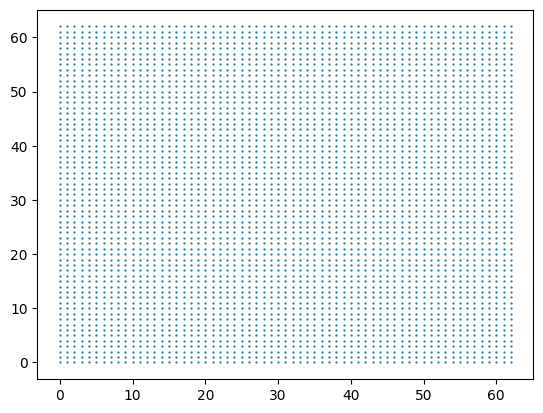

In [7]:
# Example edge index (assume static for simplicity)
edge_index = np.array([
    [n for n in range(len(gdf)) for _ in range(len(gdf))],  # Source nodes
    [n for _ in range(len(gdf)) for n in range(len(gdf))]   # Target nodes
], dtype=np.int32)

plt.scatter(edge_index[0,:], edge_index[1,:], s = 0.4)

In [8]:
# compute distances for each node by leveraging that index of gdf matches with locationids
distances = []
for i in tqdm(range(edge_index.shape[-1])):
  pulocation = edge_index[0,i] ; dolocation = edge_index[1,i]
  pu_lon = gdf.iloc[pulocation].lon ; pu_lat = gdf.iloc[pulocation].lat
  do_lon = gdf.iloc[dolocation].lon ; do_lat = gdf.iloc[dolocation].lat
  distances.append(geodesic((pu_lat, pu_lon), (do_lat, do_lon)).meters)
distances = np.array(distances)

  0%|          | 0/3969 [00:00<?, ?it/s]

In [29]:
distances

array([   0.        , 3996.76963674, 3551.40299013, ..., 9338.96497326,
        493.23886622,    0.        ])

In [30]:
distances.shape

(3969,)

In [ ]:
# example
pulocation = 21
dolocation = 34
idx = 63 * 21 + 34
print('The Distance Between Zone {} and Zone {} is {}'.format(edge_index[0,idx], edge_index[1,idx], distances[idx]))

The Distance Between Zone 21 and Zone 34 is 1097.3567770103864


In [31]:
ts.describe()

,Unnamed: 0,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
count,1.236501e+06,1.236501e+06,1.236501e+06,1.236501e+06,1.236501e+06,1.236501e+06,1.236501e+06,1.236501e+06,1.236501e+06
mean,6.182500e+05,3.100000e+01,5.432725e+01,2.162443e+01,2.909732e+00,1.484327e+01,2.467063e+00,1.390634e+00,1.253285e+01
std,3.569472e+05,1.818425e+01,7.292824e+01,6.142929e+00,1.494846e+00,5.542959e+00,1.147008e+00,3.366804e-01,4.566136e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,3.813000e-01,1.428571e-03,1.000000e-02,1.000000e-02,1.000000e+00,1.666667e-02
25%,3.091250e+05,1.500000e+01,3.000000e+00,1.834032e+01,2.260000e+00,1.179272e+01,1.787045e+00,1.232558e+00,9.775105e+00
50%,6.182500e+05,3.100000e+01,2.200000e+01,2.038141e+01,2.632969e+00,1.341021e+01,2.115000e+00,1.366667e+00,1.192938e+01
75%,9.273750e+05,4.700000e+01,8.100000e+01,2.364587e+01,3.118577e+00,1.630000e+01,2.806250e+00,1.500000e+00,1.482857e+01
max,1.236500e+06,6.200000e+01,8.590000e+02,8.410000e+02,1.663600e+02,8.400000e+02,2.177400e+02,6.000000e+00,5.943834e+02


In [32]:
ts.counts.max()

859

In [33]:
ts.counts.min()

0

### Edge Weights [Shape (N,)]

In [9]:
# define edge weights via inverse distances, normalize from 0 to 1 (standard approach doesn't work)
edge_weights = distances
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())
edge_weights = 1. - edge_weights

In [10]:
# as expected, the strongest weights are assigned to loops
edge_index[0, edge_weights == 1.], edge_index[1, edge_weights == 1.]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], dtype=int32))

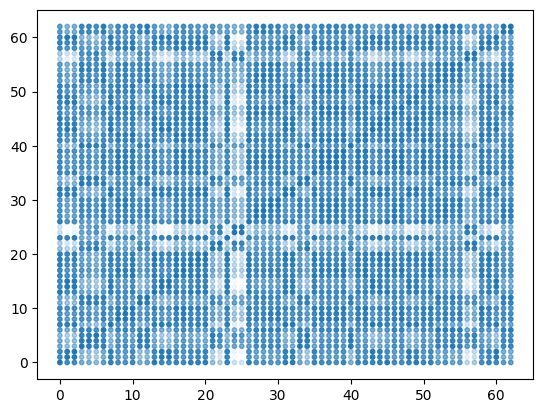

In [36]:
# visualizing the weights (diagonal should correspond to maximum edges)
plt.scatter(edge_index[0,:], edge_index[1,:], s = 10, alpha = edge_weights)

### Node Features [Shape (T, N, O)]
All of my hard work with edge features paid off. Because everything goes as before.

In [11]:
# double-check for null values in data
print(ts.isnull().sum())

# for now, just replace these values with 0 and fix later
ts = ts.fillna(0)

Unnamed: 0         0
PULocationID       0
pickup_datetime    0
counts             0
total_amount       0
tip_amount         0
fare_amount        0
trip_distance      0
passenger_count    0
trip_duration      0
dtype: int64


In [38]:
ts.counts.unique()

array([  8,   1,  10,   9,   2,  89, 136,  69, 135,  13, 190,  23,  82,
         3, 108,  53,  98,   0,  48,  33, 101, 126,  20,  37,  90,  30,
       115,  86,  74,  85, 159,  34,  26,   6,  75,  61,  14,  49, 124,
        93, 155,  70, 131, 132,  31,   4,  54, 195, 100, 120,  12,  25,
       276,  11, 138,  45,  92,   5,  40,  77,  27, 125, 141,  55, 113,
        24,  56, 122, 107, 106, 175, 147,  60,  73, 109,  15, 142,  22,
        19, 191,  97, 258,  21,  80,  29,  42,  65,  84, 116,  79,  78,
       128,  39,  64,  38,  81,  47,  32,  52,   7, 162, 205,  63,  58,
        18,  44,  28,  35,  88,  59,  68, 102, 117,  16,  50,  36,  17,
        57,  46,  66,  43,  72,  51,  95, 137,  99,  94,  83,  76,  71,
        62,  96,  87, 133, 103,  41, 110,  67, 111, 121,  91, 112, 152,
       164, 104, 143, 140, 114, 118, 130, 160, 170, 210, 105, 154, 156,
       148, 127, 168, 184, 145, 146, 232, 158, 171, 151, 129, 144, 119,
       150, 153, 213, 237, 123, 139, 198, 228, 134, 260, 215, 20

In [39]:
len(ts.counts)

1236501

In [40]:
ts.PULocationID.max(), ts.PULocationID.min()

(62, 0)

In [12]:
# create the numpy version of dataframe by pivoting dataframe
output_columns_ = ['counts', 'trip_distance', 'passenger_count', 'trip_duration']
pivoted_ts_ = ts.pivot_table(index='pickup_datetime', columns='PULocationID', values=output_columns_, aggfunc='first', sort = False) # sort = False to preserve order of columns

# Convert to a NumPy array
node_features_ = pivoted_ts_.to_numpy()

# Reshape the array to the desired shape
num_times_ = len(ts['pickup_datetime'].unique())
num_nodes_ = len(ts['PULocationID'].unique())
num_outputs_ = len(output_columns_)

In [42]:
num_times_

19627

In [ ]:
num_nodes_

63

In [ ]:
num_outputs_

4

In [ ]:
pivoted_ts_.columns

MultiIndex([(       'counts',  0),
            (       'counts',  1),
            (       'counts',  2),
            (       'counts',  3),
            (       'counts',  4),
            (       'counts',  5),
            (       'counts',  6),
            (       'counts',  7),
            (       'counts',  8),
            (       'counts',  9),
            ...
            ('trip_duration', 53),
            ('trip_duration', 54),
            ('trip_duration', 55),
            ('trip_duration', 56),
            ('trip_duration', 57),
            ('trip_duration', 58),
            ('trip_duration', 59),
            ('trip_duration', 60),
            ('trip_duration', 61),
            ('trip_duration', 62)],
           names=[None, 'PULocationID'], length=252)

In [ ]:
node_features_

array([[ 8.        ,  1.        , 10.        , ..., 14.2300005 ,
         9.25591469,  7.87343264],
       [ 9.        ,  0.        ,  6.        , ..., 14.29111099,
         7.20289898,  8.45281696],
       [22.        ,  0.        ,  3.        , ..., 15.91060543,
         7.95396805,  8.21940613],
       ...,
       [ 4.        ,  0.        ,  3.        , ..., 12.88666725,
         9.19687462,  8.52459049],
       [ 1.        ,  0.        ,  3.        , ..., 12.5       ,
         9.17708397,  8.89679527],
       [ 0.        ,  0.        ,  2.        , ...,  5.64166641,
         6.87666607,  6.67698431]])

In [ ]:
node_features_.shape

(19627, 252)

In [ ]:
len(ts.pickup_datetime)

1236501

In [ ]:
ts.pickup_datetime.unique()

<DatetimeArray>
['2022-01-01 00:00:00-05:00', '2022-01-01 01:00:00-05:00',
 '2022-01-01 02:00:00-05:00', '2022-01-01 03:00:00-05:00',
 '2022-01-01 04:00:00-05:00', '2022-01-01 05:00:00-05:00',
 '2022-01-01 06:00:00-05:00', '2022-01-01 07:00:00-05:00',
 '2022-01-01 08:00:00-05:00', '2022-01-01 09:00:00-05:00',
 ...
 '2024-03-31 14:00:00-04:00', '2024-03-31 15:00:00-04:00',
 '2024-03-31 16:00:00-04:00', '2024-03-31 17:00:00-04:00',
 '2024-03-31 18:00:00-04:00', '2024-03-31 19:00:00-04:00',
 '2024-03-31 20:00:00-04:00', '2024-03-31 21:00:00-04:00',
 '2024-03-31 22:00:00-04:00', '2024-03-31 23:00:00-04:00']
Length: 19627, dtype: datetime64[us, America/New_York]

In [ ]:
ts.counts.nunique()

619

In [43]:
pivoted_ts_

counts                                     ...  \
PULocationID                  0  1   2   3   4  5   6  7    8    9   ...   
pickup_datetime                                                      ...   
2022-01-01 00:00:00-05:00      8  1  10  10   9  2  89  9  136   69  ...   
2022-01-01 01:00:00-05:00      9  0   6  13  13  4  54  4  195  100  ...   
2022-01-01 02:00:00-05:00     22  0   3   3   5  5  19  3  191   90  ...   
2022-01-01 03:00:00-05:00      5  0   0   2  12  3   7  1  162   38  ...   
2022-01-01 04:00:00-05:00      5  0   0   2   2  0   4  1  102   19  ...   
...                          ... ..  ..  ..  .. ..  .. ..  ...  ...  ...   
2024-03-31 19:00:00-04:00      4  2  20   6   4  2  63  6  109   17  ...   
2024-03-31 20:00:00-04:00      2  3  12  15  12  4  29  7  118   18  ...   
2024-03-31 21:00:00-04:00      4  0   3   8   6  4  25  3  117   13  ...   
2024-03-31 22:00:00-04:00      1  0   3   2   7  0  12  1  100    4  ...   
2024-03-31 23:00:00-04:00      0  0   2   1   4  2   3  2   72    5  ...   

                          trip_duration                                   \
PULocationID                         53         54         55         56   
pickup_datetime                                                            
2022-01-01 00:00:00-05:00     10.074516  10.403095  10.272392  11.833333   
2022-01-01 01:00:00-05:00      9.158504   9.983056  10.541358  17.032413   
2022-01-01 02:00:00-05:00      7.881560  10.727083  10.994552   8.566667   
2022-01-01 03:00:00-05:00      8.240351   9.244445  10.346492  17.032413   
2022-01-01 04:00:00-05:00      7.272222   7.994444   8.795556  17.032413   
...                                 ...        ...        ...        ...   
2024-03-31 19:00:00-04:00      8.246714  10.106667   9.463141  17.032413   
2024-03-31 20:00:00-04:00      7.970671   8.883871  10.075238   5.650000   
2024-03-31 21:00:00-04:00      9.343148   9.805443   9.776256   7.700000   
2024-03-31 22:00:00-04:00      9.310417   9.627381  10.246511  17.032413   
2024-03-31 23:00:00-04:00      9.284000   9.886111  11.026470  17.032413   

                                                                       \
PULocationID                      57         58         59         60   
pickup_datetime                                                         
2022-01-01 00:00:00-05:00  11.127777  14.168571  12.456313  14.230000   
2022-01-01 01:00:00-05:00  11.641667  11.968493  12.220030  14.291111   
2022-01-01 02:00:00-05:00  15.168828  12.137797  11.012191  15.910605   
2022-01-01 03:00:00-05:00  15.168828  10.183088  10.190166  16.777084   
2022-01-01 04:00:00-05:00   2.416667   9.840740  11.881112   8.258333   
...                              ...        ...        ...        ...   
2024-03-31 19:00:00-04:00  12.250000  12.710000  11.431362  18.170140   
2024-03-31 20:00:00-04:00   7.983333  10.718287  11.705976  18.202564   
2024-03-31 21:00:00-04:00  12.756666  11.210677  11.620797  12.886667   
2024-03-31 22:00:00-04:00   9.433333  12.481046  12.170445  12.500000   
2024-03-31 23:00:00-04:00  11.383333   8.076282   9.940179   5.641666   

                                                
PULocationID                      61        62  
pickup_datetime                                 
2022-01-01 00:00:00-05:00   9.255915  7.873433  
2022-01-01 01:00:00-05:00   7.202899  8.452817  
2022-01-01 02:00:00-05:00   7.953968  8.219406  
2022-01-01 03:00:00-05:00   7.525000  7.188798  
2022-01-01 04:00:00-05:00  10.766666  7.809896  
...                              ...       ...  
2024-03-31 19:00:00-04:00  10.110215  7.688675  
2024-03-31 20:00:00-04:00   9.098889  8.332857  
2024-03-31 21:00:00-04:00   9.196875  8.524591  
2024-03-31 22:00:00-04:00   9.177084  8.896795  
2024-03-31 23:00:00-04:00   6.876666  6.676984  

[19627 rows x 252 columns]

In [13]:
# trick in getting pivot_table to work:
# see scratch/df_to_np.ipynb where I found the solution by working with toy data

# reshape manually to get the desired shape
idx_ = np.arange(0, num_outputs_*num_nodes_).reshape((num_outputs_, num_nodes_))
idx_.T.flatten()
node_features_ = node_features_[:, idx_.T.flatten()].reshape((num_times_, num_nodes_, num_outputs_))

In [45]:
idx_

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62],
       [ 63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
       [126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 1

In [46]:
node_features_.shape

(19627, 63, 4)

In [14]:
# Create node features
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split



In [15]:
lags = 24
train_ratio = 0.8

standardized_features_ = (
    node_features_ - np.mean(node_features_, axis=0)
) / np.std(node_features_, axis=0)

features_ = [
    standardized_features_[i : i + lags, :, 0].T
    for i in range(node_features_.shape[0] - lags)
]
targets_ = [
    standardized_features_[i + lags, :, 0].T
    for i in range(node_features_.shape[0] - lags)
]
dataset_ = StaticGraphTemporalSignal(edge_index, edge_weights, features_, targets_)
train_dataset_, test_dataset_ = temporal_signal_split(dataset_, train_ratio=train_ratio)


In [16]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU, GConvLSTM, DCRNN, TGCN2


In [17]:

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 64, K = 1, normalization = 'rw')
        self.linear = torch.nn.Linear(64,64)
        self.linear_2 = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        h = F.relu(h)
        h = self.linear_2(h)
        return h

class LSTMGCN(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(LSTMGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, out_channels, K = 1, normalization = 'sym')
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h[0])
        h = self.linear(h)
        return h

class DiffConvRNN(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(DiffConvRNN, self).__init__()
        self.recurrent = DCRNN(node_features, out_channels, K = 1)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

class TempGCN2(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(TempGCN2, self).__init__()
        self.recurrent = TGCN2(node_features, out_channels, batch_size = 40)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [18]:
N_epochs = 15
N_snapshots = train_dataset_.snapshot_count
model = LSTMGCN(node_features=lags, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

model.train()

LSTMGCN(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(24, 64, K=1, normalization=sym)
    (conv_h_i): ChebConv(64, 64, K=1, normalization=sym)
    (conv_x_f): ChebConv(24, 64, K=1, normalization=sym)
    (conv_h_f): ChebConv(64, 64, K=1, normalization=sym)
    (conv_x_c): ChebConv(24, 64, K=1, normalization=sym)
    (conv_h_c): ChebConv(64, 64, K=1, normalization=sym)
    (conv_x_o): ChebConv(24, 64, K=1, normalization=sym)
    (conv_h_o): ChebConv(64, 64, K=1, normalization=sym)
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [19]:


# N_snapshots = int(np.floor((len(node_features) - lags) * train_ratio))
pbar_epoch = tqdm(range(N_epochs), desc = 'Epoch: ', position = 0)

train_losses = val_losses = []
min_val_loss = torch.inf
counter = 0
for epoch in pbar_epoch:
    losses = []
    pbar_time = tqdm(range(N_snapshots), desc = 'Time: ', position = 1)
    for time in pbar_time:
        snapshot = train_dataset_[time]
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()

        if time % 50 == 0:
          pbar_time.set_postfix_str("Avg Snapshot Loss: {:.6f}".format(
                  sum(losses[-50:]) / 50
              ))

    losses = torch.tensor(losses)
    train_loss = losses.sum() / (time + 1)

    with torch.no_grad():
      val_loss = 0
      for time, snapshot in enumerate(test_dataset_):
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
          val_loss = val_loss + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
      val_loss = val_loss / (time+1)
      val_loss = val_loss.item()

    # early stopping
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      counter = 0
    else:
      counter += 1

    if counter == 5:
      break

    pbar_epoch.set_postfix_str("Train Loss: {:.6f}, Val Loss: {:.6f}, Early Stop Counts: {}: ".format(
        train_loss, val_loss, counter
    ))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

In [20]:
losses = [losses[i].detach().numpy() for i in range(len(losses))]

In [21]:
losses

[array(0.08882957, dtype=float32),
 array(1.7433782, dtype=float32),
 array(0.1235287, dtype=float32),
 array(0.11280213, dtype=float32),
 array(0.08666067, dtype=float32),
 array(0.0970268, dtype=float32),
 array(0.05967593, dtype=float32),
 array(0.08047937, dtype=float32),
 array(0.13961524, dtype=float32),
 array(0.1411483, dtype=float32),
 array(0.07306312, dtype=float32),
 array(0.07958445, dtype=float32),
 array(0.17903967, dtype=float32),
 array(0.24934524, dtype=float32),
 array(0.20185307, dtype=float32),
 array(0.21542823, dtype=float32),
 array(0.18732241, dtype=float32),
 array(0.3461658, dtype=float32),
 array(0.256936, dtype=float32),
 array(0.18313767, dtype=float32),
 array(0.15727505, dtype=float32),
 array(0.07945762, dtype=float32),
 array(0.08557367, dtype=float32),
 array(0.10533171, dtype=float32),
 array(0.0612324, dtype=float32),
 array(0.06779659, dtype=float32),
 array(0.05826038, dtype=float32),
 array(0.04656876, dtype=float32),
 array(0.04461389, dtype=flo

In [22]:
len(losses)

15682

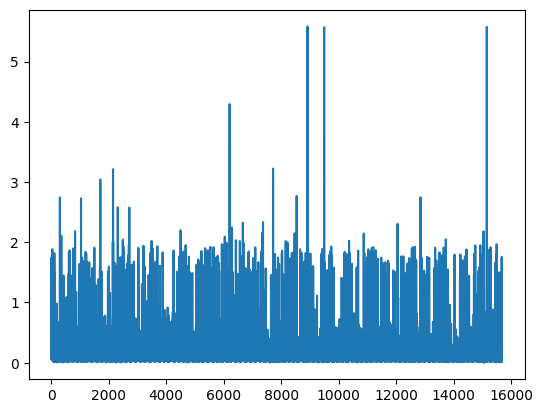

In [23]:
plt.plot(losses)

In [24]:
model.eval()
cost = 0
y_pred = []
y_act = []
for time, snapshot in enumerate(test_dataset_):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
    y_pred.append(y_hat)
    y_act.append(snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2363


In [25]:
y_pred_np = torch.stack(y_pred).detach().numpy()


In [26]:
y_pred_np

array([[[-0.43465453],
        [ 1.3233707 ],
        [ 0.77556926],
        ...,
        [ 1.4324832 ],
        [ 0.803825  ],
        [ 0.43089485]],

       [[-0.18841422],
        [ 0.7700801 ],
        [ 1.0982089 ],
        ...,
        [ 1.2646229 ],
        [ 0.8375557 ],
        [ 0.7052243 ]],

       [[-0.12315458],
        [ 0.30283403],
        [ 1.0177763 ],
        ...,
        [ 1.8910749 ],
        [ 1.0394245 ],
        [ 1.2034822 ]],

       ...,

       [[-0.01196137],
        [-0.104927  ],
        [-0.41931558],
        ...,
        [-0.26358163],
        [-0.74998385],
        [-0.23766017]],

       [[ 0.20785503],
        [-0.38099837],
        [-0.77406746],
        ...,
        [-0.65596366],
        [-0.9620002 ],
        [-0.67837197]],

       [[-0.05200934],
        [-0.3861794 ],
        [-1.0072236 ],
        ...,
        [-0.69425815],
        [-1.1693101 ],
        [-1.2498946 ]]], dtype=float32)

In [27]:
y_pred_np.shape

(3921, 63, 1)

In [28]:
y_act_np = torch.stack(y_act).detach().numpy()

In [29]:
y_act_np

array([[ 0.05514522,  0.1557901 ,  1.1656413 , ...,  1.0198019 ,
         0.5127701 ,  0.90148884],
       [-0.24256766,  0.1557901 ,  0.52617604, ...,  1.7235601 ,
         1.2721133 ,  1.5039746 ],
       [-0.24256766, -0.22128381,  1.3787963 , ...,  1.211736  ,
         0.7577195 ,  1.095145  ],
       ...,
       [ 0.05514522, -0.59835774, -0.96590954, ..., -0.5156706 ,
        -0.8589466 , -0.3680347 ],
       [-0.3914241 , -0.59835774, -0.96590954, ..., -0.64362663,
        -1.0549061 , -1.1211418 ],
       [-0.5402805 , -0.59835774, -1.0191983 , ..., -1.0274948 ,
        -1.128391  , -1.2287285 ]], dtype=float32)

In [ ]:
y_act_np.shape

(3921, 63)

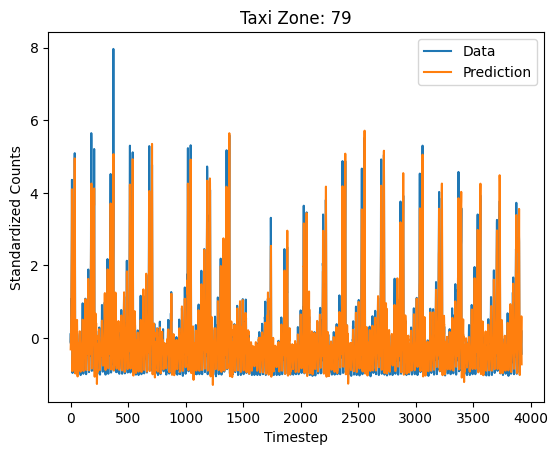

In [30]:
idx = mapping[79]
plt.plot(y_act_np[:,idx], label = 'Data')
plt.plot(y_pred_np[:,idx,0], label = 'Prediction')
plt.title('Taxi Zone: {}'.format(79))
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

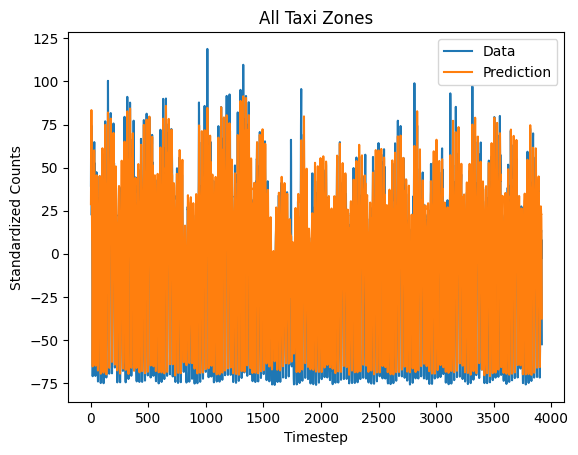

In [31]:
plt.plot(np.sum(y_act_np, axis = 1), label = 'Data')
plt.plot(np.sum(y_pred_np[:,:,0], axis = 1), label = 'Prediction')
plt.title('All Taxi Zones')
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

In [ ]:
### End of work by Naz

In [ ]:
# create the numpy version of dataframe by pivoting dataframe
output_columns = ['counts', 'total_amount', 'tip_amount', 'fare_amount', 'trip_distance', 'passenger_count', 'trip_duration']
pivoted_ts = ts.pivot_table(index='pickup_datetime', columns='PULocationID', values=output_columns, aggfunc='first', sort = False) # sort = False to preserve order of columns

# Convert to a NumPy array
node_features = pivoted_ts.to_numpy()

# Reshape the array to the desired shape
num_times = len(ts['pickup_datetime'].unique())
num_nodes = len(ts['PULocationID'].unique())
num_outputs = len(output_columns)

In [ ]:
pivoted_ts

counts                                       ...  \
PULocationID                  0  1   2   3   4  5    6   7    8    9   ...   
pickup_datetime                                                        ...   
2023-01-01 00:00:00-05:00     12  1  13  15  16  2   84   7   99   63  ...   
2023-01-01 01:00:00-05:00     24  1  14   7  17  2   66  13  149  104  ...   
2023-01-01 02:00:00-05:00     35  0   9   6  16  9   25  13  197   88  ...   
2023-01-01 03:00:00-05:00     20  0   4   5  13  6   13   7  203   71  ...   
2023-01-01 04:00:00-05:00      8  0   3   7   7  0    3   3  161   46  ...   
...                          ... ..  ..  ..  .. ..  ...  ..  ...  ...  ...   
2023-03-31 19:00:00-04:00      5  1  64  19  15  8  110   6  191   46  ...   
2023-03-31 20:00:00-04:00      7  1  34  19   6  8  111   7  141   29  ...   
2023-03-31 21:00:00-04:00      5  0  23   5  20  2   73  12  185   31  ...   
2023-03-31 22:00:00-04:00     14  1  11   7  10  1   36  10  304   43  ...   
2023-03-31 23:00:00-04:00     16  2  10   4  10  3   29   8  291   66  ...   

                          trip_duration                                   \
PULocationID                         53         54         55         56   
pickup_datetime                                                            
2023-01-01 00:00:00-05:00     10.115144  11.820911  10.909839  16.049999   
2023-01-01 01:00:00-05:00      9.689474  11.702231  11.127160   7.725000   
2023-01-01 02:00:00-05:00      9.413636  10.807353  10.014239   7.300000   
2023-01-01 03:00:00-05:00      8.063889  10.560898   8.893915   8.166667   
2023-01-01 04:00:00-05:00      9.201667  10.534444   8.215000  16.977047   
...                                 ...        ...        ...        ...   
2023-03-31 19:00:00-04:00      9.390904   9.609040  10.696539  16.977047   
2023-03-31 20:00:00-04:00      9.065369   8.709828   8.897381  12.600000   
2023-03-31 21:00:00-04:00     10.366234  10.148246  10.728185  27.466667   
2023-03-31 22:00:00-04:00      9.738399  10.218982  12.261443  14.200000   
2023-03-31 23:00:00-04:00      9.239721  10.777082  10.650001   7.800000   

                                                                       \
PULocationID                      57         58         59         60   
pickup_datetime                                                         
2023-01-01 00:00:00-05:00   9.494445  20.127144  16.296503  16.343939   
2023-01-01 01:00:00-05:00   8.202778  19.274706  16.714256  12.005882   
2023-01-01 02:00:00-05:00   9.986667  12.867969  13.177565  13.079166   
2023-01-01 03:00:00-05:00  11.933333  11.352489  12.851648  14.965152   
2023-01-01 04:00:00-05:00  12.424999   9.557142  13.147883  13.737500   
...                              ...        ...        ...        ...   
2023-03-31 19:00:00-04:00  21.083334  12.396839  11.807359  15.376344   
2023-03-31 20:00:00-04:00   5.416667  11.463369  12.496519  15.246212   
2023-03-31 21:00:00-04:00  15.183333  11.722674  14.330116  15.272223   
2023-03-31 22:00:00-04:00   5.795834  11.901423  14.100699  17.286364   
2023-03-31 23:00:00-04:00  14.756871  13.606322  13.661240  20.358770   

                                                 
PULocationID                      61         62  
pickup_datetime                                  
2023-01-01 00:00:00-05:00   8.612931   9.093296  
2023-01-01 01:00:00-05:00   8.208772   9.199344  
2023-01-01 02:00:00-05:00  10.088096   9.136796  
2023-01-01 03:00:00-05:00   8.239394   8.427062  
2023-01-01 04:00:00-05:00   7.112963   6.774243  
...                              ...        ...  
2023-03-31 19:00:00-04:00  12.483085  11.157265  
2023-03-31 20:00:00-04:00   9.334641   8.825067  
2023-03-31 21:00:00-04:00  10.411404   9.652198  
2023-03-31 22:00:00-04:00   7.238235  11.116220  
2023-03-31 23:00:00-04:00  13.640000  10.704647  

[2159 rows x 441 columns]

In [ ]:
# trick in getting pivot_table to work:
# see scratch/df_to_np.ipynb where I found the solution by working with toy data

# reshape manually to get the desired shape
idx = np.arange(0, num_outputs*num_nodes).reshape((num_outputs, num_nodes))
idx.T.flatten()
node_features = node_features[:, idx.T.flatten()].reshape((num_times, num_nodes, num_outputs))

In [ ]:
node_features[0,0,:]

array([12.        , 25.77499962,  3.71666646, 17.05833244,  2.83749986,
        1.58333337, 14.91666698])

In [ ]:
ts

,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,0,2023-01-01 00:00:00-05:00,12,25.775000,3.716666,17.058332,2.837500,1.583333,14.916667
1,1,2023-01-01 00:00:00-05:00,1,20.520000,3.420000,12.100000,1.900000,1.000000,10.550000
2,2,2023-01-01 00:00:00-05:00,13,25.891539,3.460769,17.430769,3.242307,1.384615,12.601282
3,3,2023-01-01 00:00:00-05:00,15,21.676001,2.880666,14.941999,2.704000,1.333333,11.192222
4,4,2023-01-01 00:00:00-05:00,16,16.241875,2.216875,10.743750,1.514375,1.375000,9.560416
...,...,...,...,...,...,...,...,...,...
136012,58,2023-03-31 23:00:00-04:00,58,24.246895,3.200345,16.046553,2.729138,1.448276,13.606322
136013,59,2023-03-31 23:00:00-04:00,347,22.284611,3.007089,14.284725,2.096571,1.484150,13.661240
136014,60,2023-03-31 23:00:00-04:00,19,33.783157,4.635789,24.147367,4.421579,1.526316,20.358770
136015,61,2023-03-31 23:00:00-04:00,25,26.451601,4.311600,17.139999,3.199600,1.680000,13.640000


In [ ]:
# Create node features
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

lags = 24
train_ratio = 0.8

standardized_features = (
    node_features - np.mean(node_features, axis=0)
) / np.std(node_features, axis=0)

features = [
    standardized_features[i : i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
targets = [
    standardized_features[i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
dataset = StaticGraphTemporalSignal(edge_index, edge_weights, features, targets)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU, GConvLSTM, DCRNN, TGCN2

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 64, K = 1, normalization = 'rw')
        self.linear = torch.nn.Linear(64,64)
        self.linear_2 = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        h = F.relu(h)
        h = self.linear_2(h)
        return h

class LSTMGCN(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(LSTMGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, out_channels, K = 1, normalization = 'sym')
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h[0])
        h = self.linear(h)
        return h

class DiffConvRNN(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(DiffConvRNN, self).__init__()
        self.recurrent = DCRNN(node_features, out_channels, K = 1)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

class TempGCN2(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(TempGCN2, self).__init__()
        self.recurrent = TGCN2(node_features, out_channels, batch_size = 40)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
N_epochs = 30
N_snapshots = train_dataset.snapshot_count
model = LSTMGCN(node_features=lags, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

model.train()

# N_snapshots = int(np.floor((len(node_features) - lags) * train_ratio))
pbar_epoch = tqdm(range(N_epochs), desc = 'Epoch: ', position = 0)

train_losses = val_losses = []
min_val_loss = torch.inf
counter = 0
for epoch in pbar_epoch:
    losses = []
    pbar_time = tqdm(range(N_snapshots), desc = 'Time: ', position = 1)
    for time in pbar_time:
        snapshot = train_dataset[time]
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()

        if time % 50 == 0:
          pbar_time.set_postfix_str("Avg Snapshot Loss: {:.6f}".format(
                  sum(losses[-50:]) / 50
              ))

    losses = torch.tensor(losses)
    train_loss = losses.sum() / (time + 1)

    with torch.no_grad():
      val_loss = 0
      for time, snapshot in enumerate(test_dataset):
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
          val_loss = val_loss + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
      val_loss = val_loss / (time+1)
      val_loss = val_loss.item()

    # early stopping
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      counter = 0
    else:
      counter += 1

    if counter == 5:
      break

    pbar_epoch.set_postfix_str("Train Loss: {:.6f}, Val Loss: {:.6f}, Early Stop Counts: {}: ".format(
        train_loss, val_loss, counter
    ))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

In [ ]:
losses = [losses[i].detach().numpy() for i in range(len(losses))]

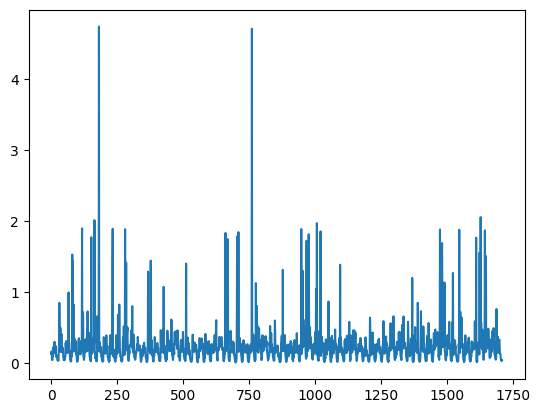

In [ ]:
plt.plot(losses)

In [ ]:
model.eval()
cost = 0
y_pred = []
y_act = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
    y_pred.append(y_hat)
    y_act.append(snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2575


In [ ]:
y_pred_np = torch.stack(y_pred).detach().numpy()
y_act_np = torch.stack(y_act).detach().numpy()

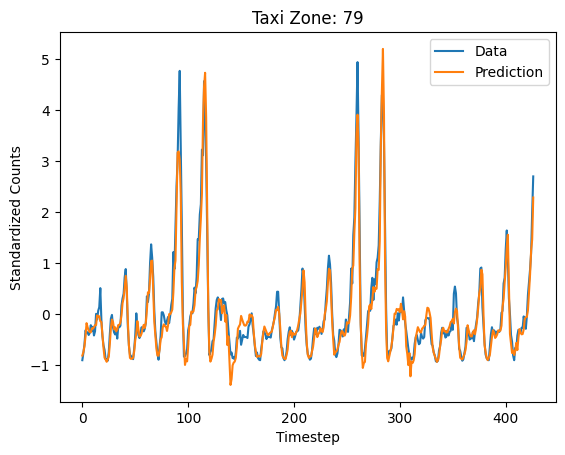

In [ ]:
idx = mapping[79]
plt.plot(y_act_np[:,idx], label = 'Data')
plt.plot(y_pred_np[:,idx,0], label = 'Prediction')
plt.title('Taxi Zone: {}'.format(79))
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

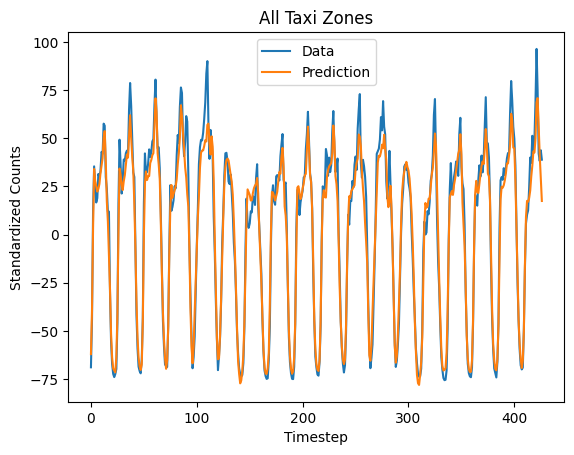

In [ ]:
plt.plot(np.sum(y_act_np, axis = 1), label = 'Data')
plt.plot(np.sum(y_pred_np[:,:,0], axis = 1), label = 'Prediction')
plt.title('All Taxi Zones')
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

In [ ]:
torch.save(model.state_dict(), '/content/mnt/My Drive/taxi_colab/LSTMGCN_3_months')

In [ ]:
# Create node features
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

lags = 24
train_ratio = 0.8

# standardized_features = (
#     node_features - np.mean(node_features, axis=0)
# ) / np.std(node_features, axis=0)

standardized_features = (
    node_features - np.mean(node_features, axis=0)
) / np.std(node_features, axis=0)
standardized_features[:,:,0] = np.log(1. + node_features[:,:,0])
standardized_features[:,:,0] = (
    standardized_features[:,:,0] - np.mean(standardized_features[:,:,0], axis=0)
) / np.std(standardized_features[:,:,0], axis=0)

features = [
    standardized_features[i : i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
targets = [
    standardized_features[i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
edge_weights_1 = edge_weights
edge_weights_2 = np.ones_like(edge_weights_1)
edge_weights = edge_weights_1
dataset = StaticGraphTemporalSignal(edge_index, edge_weights, features, targets)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)


In [ ]:
N_epochs = 10
N_snapshots = train_dataset.snapshot_count
model = LSTMGCN(node_features=lags, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

model.train()

# N_snapshots = int(np.floor((len(node_features) - lags) * train_ratio))
pbar_epoch = tqdm(range(N_epochs), desc = 'Epoch: ', position = 0)

train_losses = val_losses = []
min_val_loss = torch.inf
counter = 0
for epoch in pbar_epoch:
    losses = []
    pbar_time = tqdm(range(N_snapshots), desc = 'Time: ', position = 1)
    for time in pbar_time:
        snapshot = train_dataset[time]
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()

        if time % 50 == 0:
          pbar_time.set_postfix_str("Avg Snapshot Loss: {:.6f}".format(
                  sum(losses[-50:]) / 50
              ))

    losses = torch.tensor(losses)
    train_loss = losses.sum() / (time + 1)

    with torch.no_grad():
      val_loss = 0
      for time, snapshot in enumerate(test_dataset):
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
          val_loss = val_loss + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
      val_loss = val_loss / (time+1)
      val_loss = val_loss.item()

    # early stopping
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      counter = 0
    else:
      counter += 1

    if counter == 5:
      break

    pbar_epoch.set_postfix_str("Train Loss: {:.6f}, Val Loss: {:.6f}, Early Stop Counter: {}".format(
        train_loss, val_loss, counter
    ))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

In [ ]:
model.eval()
cost = 0
y_pred = []
y_act = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
    y_pred.append(y_hat)
    y_act.append(snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2086


In [ ]:
y_pred_np = torch.stack(y_pred).detach().numpy()
y_act_np = torch.stack(y_act).detach().numpy()

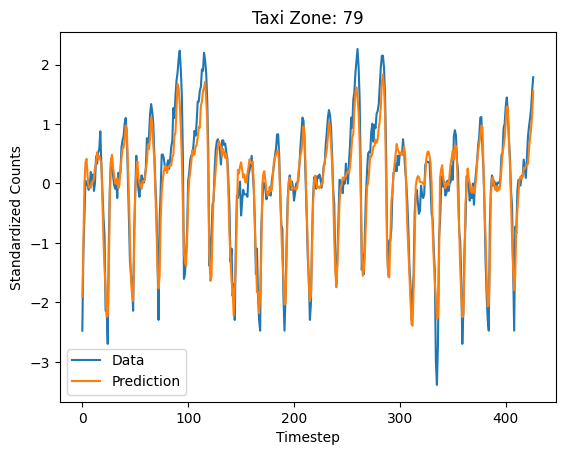

In [ ]:
idx = mapping[79]
plt.plot(y_act_np[:,idx], label = 'Data')
plt.plot(y_pred_np[:,idx,0], label = 'Prediction')
plt.title('Taxi Zone: {}'.format(79))
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

In [ ]:
# Create node features
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

lags = 24
train_ratio = 0.8

# standardized_features = (
#     node_features - np.min(node_features, axis=0)
# ) / (np.max(node_features, axis = 0) - np.min(node_features, axis = 0) )
# standardized_features[:,:,0] = np.log(1. + node_features[:,:,0])
# standardized_features[:,:,0] = (
#     standardized_features[:,:,0] - np.min(standardized_features[:,:,0], axis=0)
# ) / (np.max(standardized_features[:,:,0], axis = 0) - np.min(standardized_features[:,:,0], axis = 0) )

standardized_features = (
    node_features - np.mean(node_features, axis=0)
) / np.std(node_features, axis=0)

features = [
    standardized_features[i : i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
targets = [
    standardized_features[i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
edge_weights_1 = edge_weights
edge_weights_2 = np.ones_like(edge_weights_1)
edge_weights = edge_weights_1
dataset = StaticGraphTemporalSignal(edge_index, edge_weights, features, targets)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)

In [ ]:
N_epochs = 10
N_snapshots = train_dataset.snapshot_count
model = LSTMGCN(node_features=lags, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

model.train()

# N_snapshots = int(np.floor((len(node_features) - lags) * train_ratio))
pbar_epoch = tqdm(range(N_epochs), desc = 'Epoch: ', position = 0)

train_losses = val_losses = []
min_val_loss = torch.inf
counter = 0
for epoch in pbar_epoch:
    losses = []
    pbar_time = tqdm(range(N_snapshots), desc = 'Time: ', position = 1)
    for time in pbar_time:
        snapshot = train_dataset[time]
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()

        if time % 50 == 0:
          pbar_time.set_postfix_str("Avg Snapshot Loss: {:.6f}".format(
                  sum(losses[-50:]) / 50
              ))

    losses = torch.tensor(losses)
    train_loss = losses.sum() / (time + 1)

    with torch.no_grad():
      val_loss = 0
      for time, snapshot in enumerate(test_dataset):
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
          val_loss = val_loss + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
      val_loss = val_loss / (time+1)
      val_loss = val_loss.item()

    # early stopping
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      counter = 0
    else:
      counter += 1

    if counter == 5:
      break

    pbar_epoch.set_postfix_str("Train Loss: {:.6f}, Val Loss: {:.6f}, Early Stop Counter: {}".format(
        train_loss, val_loss, counter
    ))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

Time:   0%|          | 0/1708 [00:00<?, ?it/s]

In [ ]:
model.eval()
cost = 0
y_pred = []
y_act = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
    y_pred.append(y_hat)
    y_act.append(snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2654


In [ ]:
y_pred_np = torch.stack(y_pred).detach().numpy()
y_act_np = torch.stack(y_act).detach().numpy()

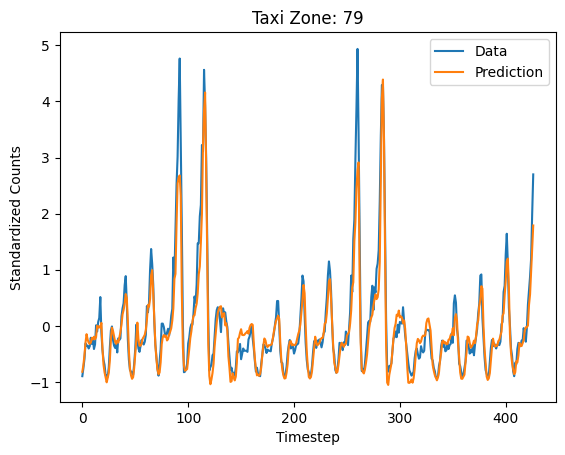

In [ ]:
idx = mapping[79]
plt.plot(y_act_np[:,idx], label = 'Data')
plt.plot(y_pred_np[:,idx,0], label = 'Prediction')
plt.title('Taxi Zone: {}'.format(79))
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

### Try Changing Normalization

In [ ]:
# Create node features
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

lags = 24

# standardized_features = (
#     node_features - np.mean(node_features, axis=0)
# ) / np.std(node_features, axis=0)
# standardized_features[:,:,0] = np.log(1. + node_features[:,:,0])
# standardized_features[:,:,0] = (
#     standardized_features[:,:,0] - np.mean(standardized_features[:,:,0], axis=0)
# ) / np.std(standardized_features[:,:,0], axis=0)

standardized_features = (
    node_features - np.min(node_features, axis=0)
) / (np.max(node_features, axis = 0) - np.min(node_features, axis = 0) )
standardized_features[:,:,0] = np.log(1. + node_features[:,:,0])
standardized_features[:,:,0] = (
    standardized_features[:,:,0] - np.min(standardized_features[:,:,0], axis=0)
) / (np.max(standardized_features[:,:,0], axis = 0) - np.min(standardized_features[:,:,0], axis = 0) )

features = [
    standardized_features[i : i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
targets = [
    standardized_features[i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
dataset = StaticGraphTemporalSignal(edge_index, edge_weights, features, targets)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)


In [ ]:
from tqdm import tqdm

model = RecurrentGCN(node_features=lags, out_channels=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

costs = []
for epoch in tqdm(range(5)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        costs.append(cost)
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 5/5 [03:34<00:00, 42.81s/it]


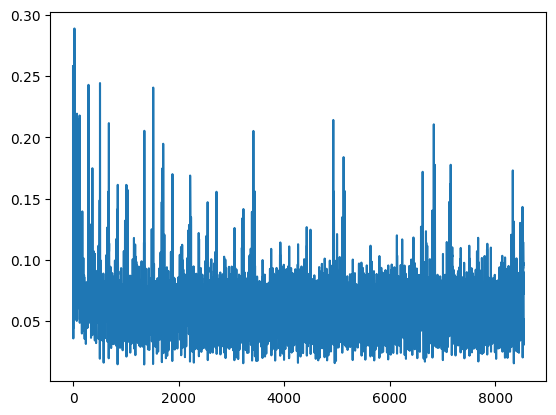

In [ ]:
costs = [costs[i].detach().numpy() for i in range(len(costs))]
plt.plot(costs)

In [ ]:
model.eval()
cost = 0
y_pred = []
y_act = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    y_pred.append(y_hat)
    y_act.append(snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.0622


In [ ]:
y_pred_np = torch.stack(y_pred).detach().numpy()
y_act_np = torch.stack(y_act).detach().numpy()

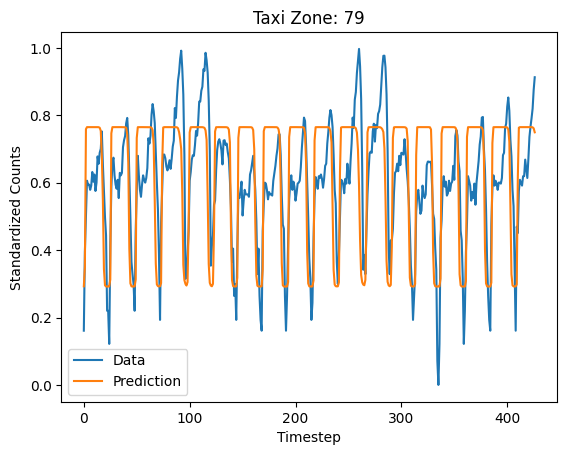

In [ ]:
idx = mapping[79]
plt.plot(y_act_np[:,idx], label = 'Data')
plt.plot(y_pred_np[:,idx,0], label = 'Prediction')
plt.title('Taxi Zone: {}'.format(79))
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()